<h1> LTestChiSquaredTests.ipynb </h1>

This code is prepared so that it condenses all the information from the code files inside TestAModelFolder/ML. 

First copy and paste the folders that CrystallineMLAlone.ipynb and AmorphousMLAlone.ipynb have created inside LTestVisualCheck (at the same level as the ipynb files).
Then run the first cell of LTestChiSquaredTests.ipynb if you want to obtain information using the chi squared metric. This cell will create a subfolder called ChiSquared where only three files are important:
 - Chi2_rank_vertical.png For every experiment, the chi squared value of the preditions of each model is obtained. Then all chi squared values of the different models in each experiment is compared. The one that has the smaller chi squared value obtains a +1, the second smallest a +2 and so on. This process is repeated for each experiment and these integer values are summed. At the end we can say that the model with the smallest score has performed better overall
 - Chi2_AccumulativeScores.txt has the same information than the graph but on a txt file
 - Chi2_NumberOfExperimentsWhereEachModelOutperforms.txt as its name indicates counts only the number of experiment where each model obtains the smallest chi squared value. Sometimes, models that overfit perform better on this test (as they pass through all the points)

Run the second folder if you want the same information using a metric similar to the Mean Average Error (MAE). Instead of summing over the differences squared and divided by the uncertainty of the prediction squared, here we are summing over the absolute value of the differences and divided by the uncertainty (not squared). By running this cell you create the subfolder Lvalues that contains the same type of information (Lvalues_rank_vertical.png, Lvalues_TotalScores.txt with the information of the graph and Lvalues_WinnerScores which is the equivalent version of Chi2_NumberOfExperimentsWhereEachModelOutperforms.txt but with The L metric

If you run the third one it will automatically combine the predictions for twelve models for each experiment in a single image. This way it is easier to spot the differences between models in a quick look. The code also orders them in order of complexity (each consecutive row has a bigger complexity) and number of augmentations (each consecutive column ahs more augmentation). This way the models are organized from simpler (top left) to more complex (bottom right).

 === WARNINGS FOR PREDICTWITHMODEL ===

THE IMAGE COMBINATION CELL HAS BEEN CREATED TO EXPECT THE NAMES NAIF, SIMPLE, AVERAGE AND COMPLEX AND FOR THERE TO BE EXACTLY 12 MODELS. IF A DIFFERENT NAME IS USED OR THERE IS A DIFFERENT NUMBER OF MODELS, IT WILL NOT WORK. PLEASE CHANGE THE CODE ACCORDINGLY. 
THE IMAGE COMBINATION CELL ALSO DOES NOT REMOVE THE TITLE OF EACH GRAPH AND DUE TO THEIR LENGTH THEY OVERLAP. APOLOGIES IN ADVANCE

<H1> CHI SQUARED TEST </H1>

 No MissingPolarizationD3_ folders in .ipynb_checkpoints
File saved: \\?\C:\Users\perez-blasco\Desktop\FolderofFolders\TestAModelFolder\LTestVisualCheck\ChiSquared\Chi2_values_AllTestsFolder_Average_3.txt
File saved: \\?\C:\Users\perez-blasco\Desktop\FolderofFolders\TestAModelFolder\LTestVisualCheck\ChiSquared\Chi2_values_AllTestsFolder_Average_5.txt
File saved: \\?\C:\Users\perez-blasco\Desktop\FolderofFolders\TestAModelFolder\LTestVisualCheck\ChiSquared\Chi2_values_AllTestsFolder_Average_7.txt
File saved: \\?\C:\Users\perez-blasco\Desktop\FolderofFolders\TestAModelFolder\LTestVisualCheck\ChiSquared\Chi2_values_AllTestsFolder_Average_9.txt
File saved: \\?\C:\Users\perez-blasco\Desktop\FolderofFolders\TestAModelFolder\LTestVisualCheck\ChiSquared\Chi2_values_AllTestsFolder_Complex_3.txt
File saved: \\?\C:\Users\perez-blasco\Desktop\FolderofFolders\TestAModelFolder\LTestVisualCheck\ChiSquared\Chi2_values_AllTestsFolder_Complex_5.txt
File saved: \\?\C:\Users\perez-blasco\Desktop\FolderofF

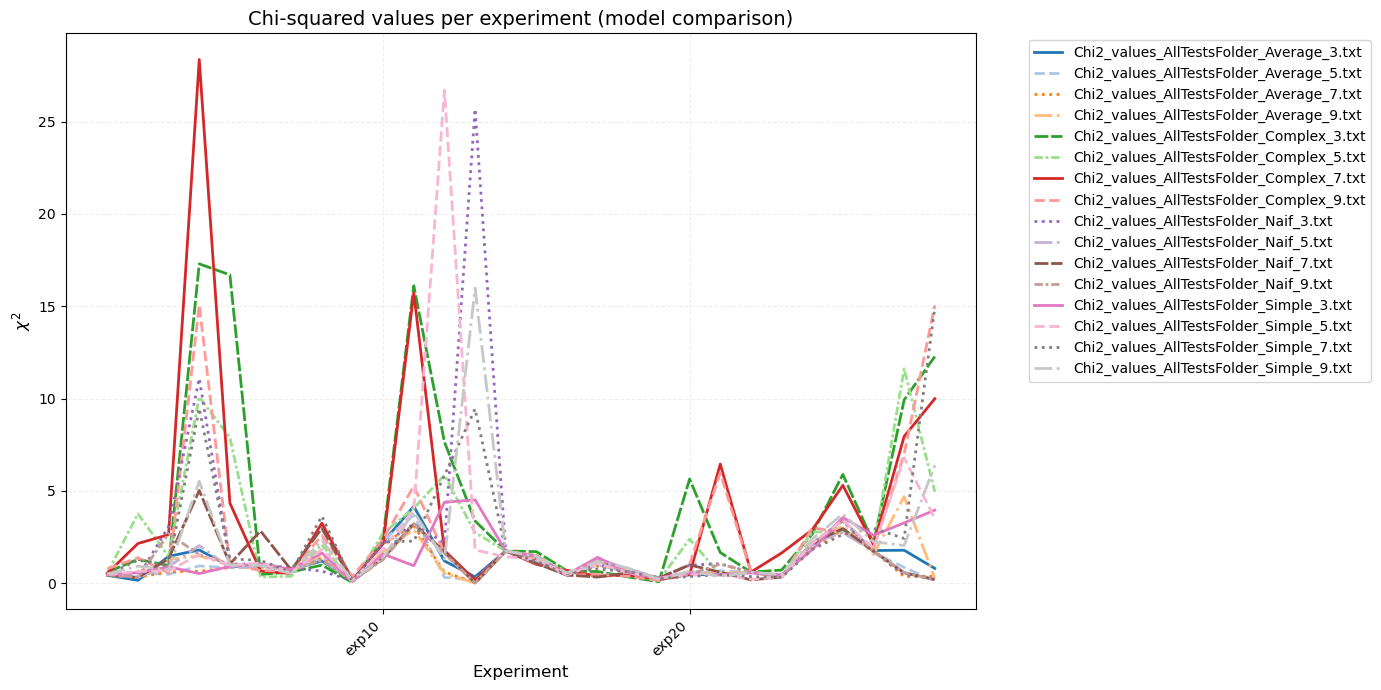

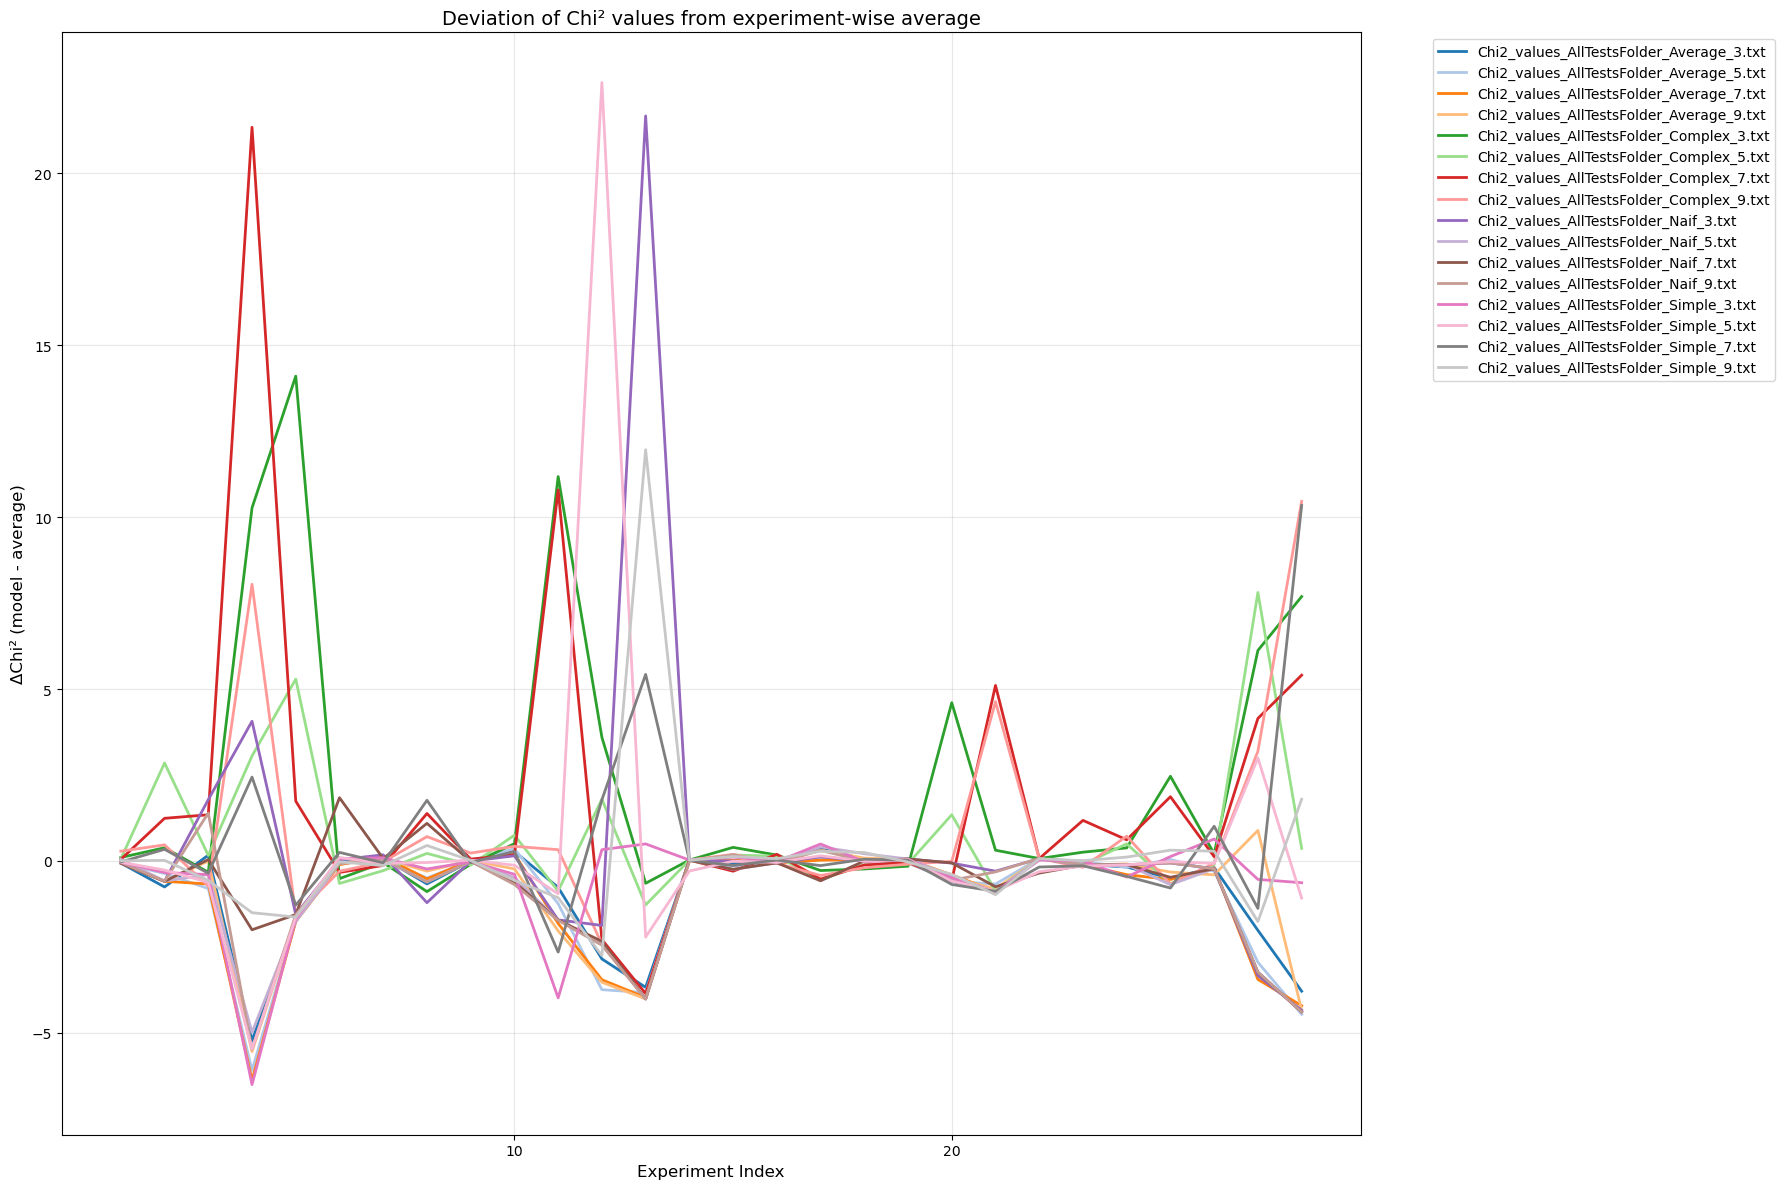

Results saved to \\?\C:\Users\perez-blasco\Desktop\FolderofFolders\TestAModelFolder\LTestVisualCheck\ChiSquared\Chi2_NumberOfExperimentsWhereEachModelOutperforms.txt
Scores saved to: \\?\C:\Users\perez-blasco\Desktop\FolderofFolders\TestAModelFolder\LTestVisualCheck\ChiSquared\Chi2_AccumulativeScores.txt


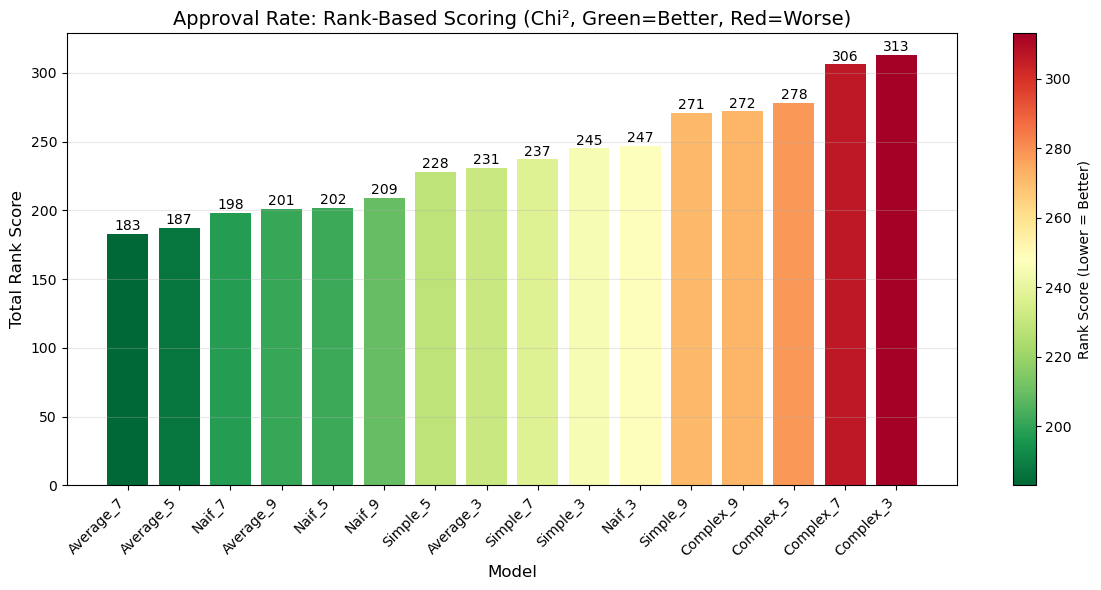

In [13]:
import os
import pandas as pd
import numpy as np

def long_path(path):
    """Return Windows long path format if on Windows."""
    if os.name == 'nt':
        path = os.path.abspath(path)
        if not path.startswith('\\\\?\\'):
            return '\\\\?\\' + path
    return path

def compute_chi2_for_experiment(df_real, df_pred):
    """
    Compute the reduced chi-squared value for one experiment:
    
        χ² = (1/N) * Σ [ (pred - real)² / (err_real)² ]
    """
    if len(df_real) != len(df_pred):
        raise ValueError("Real and predicted files must have the same length.")
    
    N = len(df_real)
    diff = df_pred["PredictedPolarizationD3"].values - df_real["RealPolarizationD3"].values
    err = df_real["ErrRealPolarizationD3"].values
    err[err == 0] = 1e-10  # avoid division by zero
    
    chi2 = np.sum((diff**2) / (err**2)) / N
    return chi2

def load_data(experiment_folder):
    """
    Load the txt files containing real and predicted data
    for a MissingPolarizationD3_* experiment.
    """
    experiment_folder = long_path(experiment_folder)
    files = os.listdir(experiment_folder)
    real_file = next(f for f in files if f.startswith("RawData_PolarizationD3_MissingPolarizationD3_"))
    pred_file = next(f for f in files if f.startswith("PredictedPoints_PolarizationD3_MissingPolarizationD3_"))

    df_real = pd.read_csv(long_path(os.path.join(experiment_folder, real_file)), sep="\t")
    df_pred = pd.read_csv(long_path(os.path.join(experiment_folder, pred_file)), sep="\t")
    return df_real, df_pred

def count_missing_folders(model_path):
    """
    Return the list of MissingPolarizationD3_* subfolders for a given model folder.
    """
    model_path = long_path(model_path)
    return sorted([
        f for f in os.listdir(model_path)
        if f.startswith("MissingPolarizationD3_") and os.path.isdir(long_path(os.path.join(model_path, f)))
    ])

def save_chi2_values_to_txt(model_folder_name, missing_folders, chi2_values, output_dir):
    """
    Save the chi-squared values to a structured text file
    inside the 'ChiSquared' folder at the root level.
    """
    chi2_dir = long_path(os.path.join(output_dir, "ChiSquared"))
    os.makedirs(chi2_dir, exist_ok=True)  # ensure folder exists

    filename = f"Chi2_values_{model_folder_name}.txt"
    filepath = long_path(os.path.join(chi2_dir, filename))

    with open(filepath, "w") as f:
        for folder_name, chi2 in zip(missing_folders, chi2_values):
            f.write(f"{folder_name}: {chi2:.6f}\n")

    print(f"File saved: {filepath}")

def main_all_models(root_folder):
    """
    Main loop over all model folders in the given root_folder.
    Each folder should contain MissingPolarizationD3_* subfolders.
    """
    root_folder = long_path(root_folder)
    all_model_folders = [
        d for d in os.listdir(root_folder)
        if os.path.isdir(long_path(os.path.join(root_folder, d)))
    ]

    if not all_model_folders:
        print("No model folders found.")
        return

    for model_folder in all_model_folders:
        #print(f"\n Processing model: {model_folder}")
        model_path = long_path(os.path.join(root_folder, model_folder))
        missing_folders = count_missing_folders(model_path)

        if not missing_folders:
            print(f" No MissingPolarizationD3_ folders in {model_folder}")
            continue

        chi2_values = []
        for missing_folder in missing_folders:
            experiment_path = long_path(os.path.join(model_path, missing_folder))
            try:
                df_real, df_pred = load_data(experiment_path)
                chi2 = compute_chi2_for_experiment(df_real, df_pred)
                chi2_values.append(chi2)
                #print(f"  {missing_folder}: χ² = {chi2:.6f}")
            except Exception as e:
                print(f"   Error in {missing_folder}: {e}")

        if chi2_values:
            save_chi2_values_to_txt(model_folder, missing_folders, chi2_values, root_folder)
            chi2_mean = np.mean(chi2_values)
            #print(f"Average χ² for {model_folder}: {chi2_mean:.6f}")
        else:
            print(f"No valid χ² values computed for {model_folder}.")

# === Example call ===
main_all_models(r".")
import os
from collections import OrderedDict

def long_path(path):
    """Return Windows long path format if on Windows."""
    if os.name == 'nt':
        path = os.path.abspath(path)
        if not path.startswith('\\\\?\\'):
            return '\\\\?\\' + path
    return path

# Folder that contains the saved chi-squared text files
folder_path = long_path("ChiSquared")

# Quick diagnostic
if not os.path.isdir(folder_path):
    print(f"Folder not found: {folder_path}")
    print("   Tip: run the computation cell first so it creates ChiSquared/ and the files.")
    
# Helper to recognize result files from either naming style
def is_result_file(name: str) -> bool:
    return (
        name.endswith(".txt") and
        (name.startswith("Chi2_values_") or name.startswith("ChiSquared_values_"))
    )

# Initialize dictionaries
Chi2Values = {}             
ExperimentName = OrderedDict() 

# Collect files
result_files = []
if os.path.isdir(folder_path):
    for filename in os.listdir(folder_path):
        if is_result_file(filename):
            result_files.append(filename)

# Sort for stable order
result_files.sort()

if not result_files:
    print("No results found in ChiSquared/ matching 'Chi2_values_*.txt' or 'ChiSquared_values_*.txt'.")
else:
    for filename in result_files:
        full_path = long_path(os.path.join(folder_path, filename))
        with open(full_path, "r") as f:
            lines = f.readlines()

        Chi2Values[filename] = {}
        for line in lines:
            if ":" in line:
                try:
                    experiment_name, value = line.split(":", 1)
                    experiment_name = experiment_name.strip()
                    value = float(value.strip())
                    Chi2Values[filename][experiment_name] = value
                except ValueError:
                    print(f"Skipping malformed line in {filename}: {line.strip()}")

        # Fill ExperimentName only from the first processed file
        if not ExperimentName and Chi2Values[filename]:
            for i, experiment_name in enumerate(Chi2Values[filename].keys(), 1):
                ExperimentName[experiment_name] = f"exp{i}"

# Display results for verification
#print("Dictionary Chi2Values:")
for filename, experiments in Chi2Values.items():
    #print(f"\n{filename}:")
    for exp, val in experiments.items():
        1==1
        #print(f"  {exp}: {val:.6f}")

#print("\nDictionary ExperimentName:")
for exp, shortname in ExperimentName.items():
    1==1
    #print(f"  {exp} → {shortname}")

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 7))

# List of experiment identifiers (exp1, exp2, ...)
exp_ids = list(ExperimentName.values())

# Ensure we have at least 2 models
assert len(Chi2Values) >= 2, "You need at least two Chi² values files"

# List of files to plot (model names)
files = list(Chi2Values.keys())

# Use modern colormap handling
colors = plt.colormaps.get_cmap('tab20').colors
line_styles = ['-', '--', ':', '-.', (0, (5, 1)), (0, (3, 1, 1, 1))]
line_widths = [2] * len(files)

# Plot the curves
for j, filename in enumerate(files):
    chi2_values = [
        Chi2Values[filename].get(exp_name, np.nan)  # Use NaN if missing
        for exp_name in ExperimentName.keys()
    ]
    
    plt.plot(
        range(len(exp_ids)),
        chi2_values,
        color=colors[j % len(colors)],
        linestyle=line_styles[j % len(line_styles)],
        linewidth=line_widths[j],
        label=filename
    )

# Show xticks every 10 experiments
xticks_pos = [i for i in range(len(exp_ids)) if (i + 1) % 10 == 0]
xticks_labels = [exp_ids[i] for i in xticks_pos]
plt.xticks(xticks_pos, xticks_labels, rotation=45, ha='right')

# Labels and title
plt.xlabel("Experiment", fontsize=12)
plt.ylabel(r"$\chi^2$", fontsize=12)
plt.title(r"Chi-squared values per experiment (model comparison)", fontsize=14)
plt.grid(alpha=0.2, linestyle='--')

# Legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
import numpy as np

# Normalize function (replace "-" by "_")
def normalize_key(k):
    return k.replace("-", "_")

# Normalize experiment names inside Chi2Values
Chi2Values_norm = {
    model: {normalize_key(exp): val for exp, val in Chi2Values[model].items()}
    for model in Chi2Values
}

# Normalize experiment names mapping
ExperimentName_norm = {normalize_key(exp): exp for exp in ExperimentName.keys()}

# Build 2D array: rows = models, cols = experiments
all_chi2_values = np.array([
    [Chi2Values_norm[f].get(exp, np.nan) for exp in ExperimentName_norm.keys()]
    for f in Chi2Values_norm.keys()
])

# Preserve the original experiment order (exp1, exp2, ...)
exp_ids = [ExperimentName_norm[exp] for exp in ExperimentName_norm.keys()]

# Keep track of model names (rows of all_chi2_values)
model_ids = list(Chi2Values_norm.keys())

# --- Debugging output ---
#print("Shape of all_chi2_values:", all_chi2_values.shape)
#print("Models:", model_ids)
#print("Experiments:", exp_ids[:10], "...")  # only show first 10 for sanity check

"""
import matplotlib.pyplot as plt
import numpy as np

# Get the model names
files = list(LValues.keys())
nb_models = len(files)

# Colors (updated for matplotlib >=3.7)
colors = plt.colormaps['tab20'](range(nb_models))

# Line styles (will repeat if needed)
line_styles = ['--', ':', '-.', (0, (3, 1, 1, 1)), (0, (5, 2))]

# Build the L values matrix (with NaN for missing experiments)
all_l_values = []
exp_ids = list(ExperimentName.keys())  # Keep original order

for f in files:
    model_l = []
    for exp in exp_ids:
        if exp not in LValues[f]:
            print(f"Warning: experiment '{exp}' is missing for model '{f}'")
            model_l.append(np.nan)  # Fill missing with NaN
        else:
            model_l.append(LValues[f][exp])
    all_l_values.append(model_l)

all_l_values = np.array(all_l_values)

# One plot per reference model
for i in range(nb_models):
    plt.figure(figsize=(18, 6))
    
    curve_count = 0
    for j in range(nb_models):
        if i == j:
            continue
        diff = all_l_values[i] - all_l_values[j]
        
        plt.plot(
            range(1, len(exp_ids) + 1),  # X axis = experiment index starting at 1
            diff,
            linestyle=line_styles[curve_count % len(line_styles)],
            linewidth=2,
            color=colors[curve_count % len(colors)],
            label=f"{files[i]} - {files[j]}"
        )
        curve_count += 1

    # X-ticks every 10 experiments
    xticks_pos = [k + 1 for k in range(len(exp_ids)) if (k + 1) % 10 == 0]
    plt.xticks(xticks_pos, rotation=0)

    plt.xlabel("Experiment Index", fontsize=12)
    plt.ylabel("Difference in L", fontsize=12)
    plt.title(f"Differences in L compared to model: {files[i]}", fontsize=14)
    plt.grid(alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
"""
import matplotlib.pyplot as plt
import numpy as np

# --- Build Chi² matrix ---
files = list(Chi2Values.keys())   # Model names (files)
nb_models = len(files)

exp_ids = list(ExperimentName.keys())  # Experiments in original order

all_chi2_values = []
for f in files:
    model_vals = []
    for exp in exp_ids:
        if exp not in Chi2Values[f]:
            print(f"Warning: experiment '{exp}' missing for model '{f}'")
            model_vals.append(np.nan)  # fill missing with NaN
        else:
            model_vals.append(Chi2Values[f][exp])
    all_chi2_values.append(model_vals)

all_chi2_values = np.array(all_chi2_values)

# --- Compute average Chi² across models for each experiment ---
avg_chi2 = np.nanmean(all_chi2_values, axis=0)  # ignore NaN when averaging

# --- Colors and line styles ---
colors = plt.colormaps['tab20'](range(nb_models))
#line_styles = ['--', ':', '-.', (0, (3, 1, 1, 1)), (0, (5, 2))]

# --- Plot deviation from the average ---
plt.figure(figsize=(18, 12))

for j in range(nb_models):
    diff_from_avg = all_chi2_values[j] - avg_chi2
    plt.plot(
        range(1, len(exp_ids) + 1),  # experiments indexed starting at 1
        diff_from_avg,
        #linestyle=line_styles[j % len(line_styles)],
        linewidth=2,
        color=colors[j % len(colors)],
        label=files[j]
    )

# X-ticks every 10 experiments
xticks_pos = [k + 1 for k in range(len(exp_ids)) if (k + 1) % 10 == 0]
plt.xticks(xticks_pos, rotation=0)

plt.xlabel("Experiment Index", fontsize=12)
plt.ylabel("ΔChi² (model - average)", fontsize=12)
plt.title("Deviation of Chi² values from experiment-wise average", fontsize=14)
plt.grid(alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
import os

# Folder to save results
output_folder = long_path("ChiSquared")
os.makedirs(output_folder, exist_ok=True)

# Initialize a dictionary to store scores
model_scores = {f: 0 for f in files}

# For each experiment (column of all_chi2_values)
for chi2_vals in all_chi2_values.T:
    # Ignore NaNs when determining the minimum
    if np.all(np.isnan(chi2_vals)):
        continue  # skip if all models missing for this experiment
    
    min_index = np.nanargmin(chi2_vals)  # index of the winning model
    winning_model = files[min_index]
    model_scores[winning_model] += 1

# Sort by descending score
sorted_scores = sorted(model_scores.items(), key=lambda x: x[1], reverse=True)

# Save to txt
output_file = os.path.join(output_folder, "Chi2_NumberOfExperimentsWhereEachModelOutperforms.txt")
with open(output_file, "w") as f:
    f.write("Approval Rate (Number of wins by minimal Chi². The higher the better):\n\n")
    for model, score in sorted_scores:
        f.write(f"{model}: {score} points\n")

print(f"Results saved to {output_file}")
import os
import numpy as np

# Ensure the ChiSquared folder exists
output_folder = long_path("ChiSquared")
os.makedirs(output_folder, exist_ok=True)

# Rebuild all_l_values from Chi2Values
files = list(Chi2Values.keys())  # model names
exp_ids = list(ExperimentName.keys())  # experiment names in original order

# Build the chi-squared matrix with NaN for missing experiments
all_chi2_values = []
for f in files:
    model_chi2 = []
    for exp in exp_ids:
        model_chi2.append(Chi2Values[f].get(exp, np.nan))
    all_chi2_values.append(model_chi2)
all_chi2_values = np.array(all_chi2_values)

# Initialize a dictionary to store rank-based scores
model_scores = {f: 0 for f in files}

# For each experiment (column)
for chi_values in all_chi2_values.T:
    sorted_indices = np.argsort(chi_values)  # best to worst
    for rank, model_idx in enumerate(sorted_indices, start=1):
        model_name = files[model_idx]
        model_scores[model_name] += rank

# Sort results by ascending score (lower is better)
sorted_scores = sorted(model_scores.items(), key=lambda x: x[1])

# Save to text file
output_file = long_path(os.path.join(output_folder, "Chi2_AccumulativeScores.txt"))
with open(output_file, "w") as f:
    f.write("Approval Rate (Score by rank. Lower is better):\n\n")
    for model, score in sorted_scores:
        f.write(f"{model}: {score} points\n")

print(f"Scores saved to: {output_file}")
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import os

# Ensure output folder exists
output_folder = long_path("ChiSquared")
os.makedirs(output_folder, exist_ok=True)
"""
# -------------------------------
# Horizontal bar chart: Wins by minimal Chi²
# -------------------------------
sorted_scores_min = sorted(model_scores.items(), key=lambda x: x[1], reverse=True)  # number of wins
models = [m for m, _ in sorted_scores_min]
scores = np.array([s for _, s in sorted_scores_min])

# Normalize scores and create colormap
norm = mcolors.Normalize(vmin=min(scores), vmax=max(scores))
cmap = plt.colormaps['RdYlGn']
colors = cmap(norm(scores))

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(models, scores, color=colors)
ax.invert_yaxis()
ax.set_xlabel("Number of Wins", fontsize=12)
ax.set_ylabel("Model", fontsize=12)
ax.set_title("Approval Rate: Wins by Minimal Chi²", fontsize=14)
ax.grid(axis='x', alpha=0.3)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(scores)
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Number of Wins (Higher = Better)")

plt.tight_layout()
plt.savefig(long_path(os.path.join(output_folder, "Chi2_wins_horizontal.png")), dpi=600, bbox_inches='tight')
plt.show()

# -------------------------------
# Vertical bar chart: Wins by minimal Chi²
# -------------------------------
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(models, scores, color=colors)

for bar, score in zip(bars, scores):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f"{score}", ha='center', va='bottom', fontsize=10)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Number of Wins (Higher = Better)")

plt.xticks(rotation=45, ha='right')
ax.set_ylabel("Number of Wins", fontsize=12)
ax.set_title("Approval Rate: Wins by Minimal Chi²", fontsize=14)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(long_path(os.path.join(output_folder, "Chi2_wins_vertical.png")), dpi=600, bbox_inches='tight')
plt.show()

# -------------------------------
# Pie chart: Proportion of wins by model
# -------------------------------
sorted_indices = np.argsort(-scores)
models_sorted = [models[i] for i in sorted_indices]
scores_sorted = scores[sorted_indices]

norm = mcolors.Normalize(vmin=min(scores_sorted), vmax=max(scores_sorted))
colors = cmap(norm(scores_sorted))

plt.figure(figsize=(8, 8))
plt.pie(
    scores_sorted,
    labels=models_sorted,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors
)
plt.title("Approval Rate: Proportion of Wins by Model (Chi²)", fontsize=14)
plt.savefig(long_path(os.path.join(output_folder, "Chi2_wins_pie.png")), dpi=600, bbox_inches='tight')
plt.show()
"""
# -------------------------------
# Vertical bar chart: Rank-based scoring (lower=better)
# -------------------------------
sorted_scores_rank = sorted(model_scores.items(), key=lambda x: x[1])  # rank-based
models = [m for m, _ in sorted_scores_rank]
scores = [s for _, s in sorted_scores_rank]

norm = plt.Normalize(min(scores), max(scores))
cmap = plt.colormaps['RdYlGn_r']  # green=best, red=worst
colors = cmap(norm(scores))
# Extract short names for X-axis
short_models = [m.replace("Chi2_values_AllTestsFolder_", "").replace(".txt", "") for m in models]

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(short_models, scores, color=colors)

# Add score labels above bars
for bar, score in zip(bars, scores):
    ax.text(bar.get_x() + bar.get_width()/2, score + 0.5,
            f"{score}", ha='center', va='bottom', fontsize=10)

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(scores)
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Rank Score (Lower = Better)")

ax.set_ylabel("Total Rank Score", fontsize=12)
ax.set_xlabel("Model", fontsize=12)
ax.set_title("Approval Rate: Rank-Based Scoring (Chi², Green=Better, Red=Worse)", fontsize=14)
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(long_path(os.path.join(output_folder, "Chi2_rank_vertical.png")), dpi=600, bbox_inches='tight')
plt.show()

<h1> L TEST </h1>

 No MissingPolarizationD3_ folders in .ipynb_checkpoints
File saved: \\?\C:\Users\perez-blasco\Desktop\FolderofFolders\TestAModelFolder\LTestVisualCheck\LValues\L_values_AllTestsFolder_Average_3.txt
File saved: \\?\C:\Users\perez-blasco\Desktop\FolderofFolders\TestAModelFolder\LTestVisualCheck\LValues\L_values_AllTestsFolder_Average_5.txt
File saved: \\?\C:\Users\perez-blasco\Desktop\FolderofFolders\TestAModelFolder\LTestVisualCheck\LValues\L_values_AllTestsFolder_Average_7.txt
File saved: \\?\C:\Users\perez-blasco\Desktop\FolderofFolders\TestAModelFolder\LTestVisualCheck\LValues\L_values_AllTestsFolder_Average_9.txt
File saved: \\?\C:\Users\perez-blasco\Desktop\FolderofFolders\TestAModelFolder\LTestVisualCheck\LValues\L_values_AllTestsFolder_Complex_3.txt
File saved: \\?\C:\Users\perez-blasco\Desktop\FolderofFolders\TestAModelFolder\LTestVisualCheck\LValues\L_values_AllTestsFolder_Complex_5.txt
File saved: \\?\C:\Users\perez-blasco\Desktop\FolderofFolders\TestAModelFolder\LTestVisualC

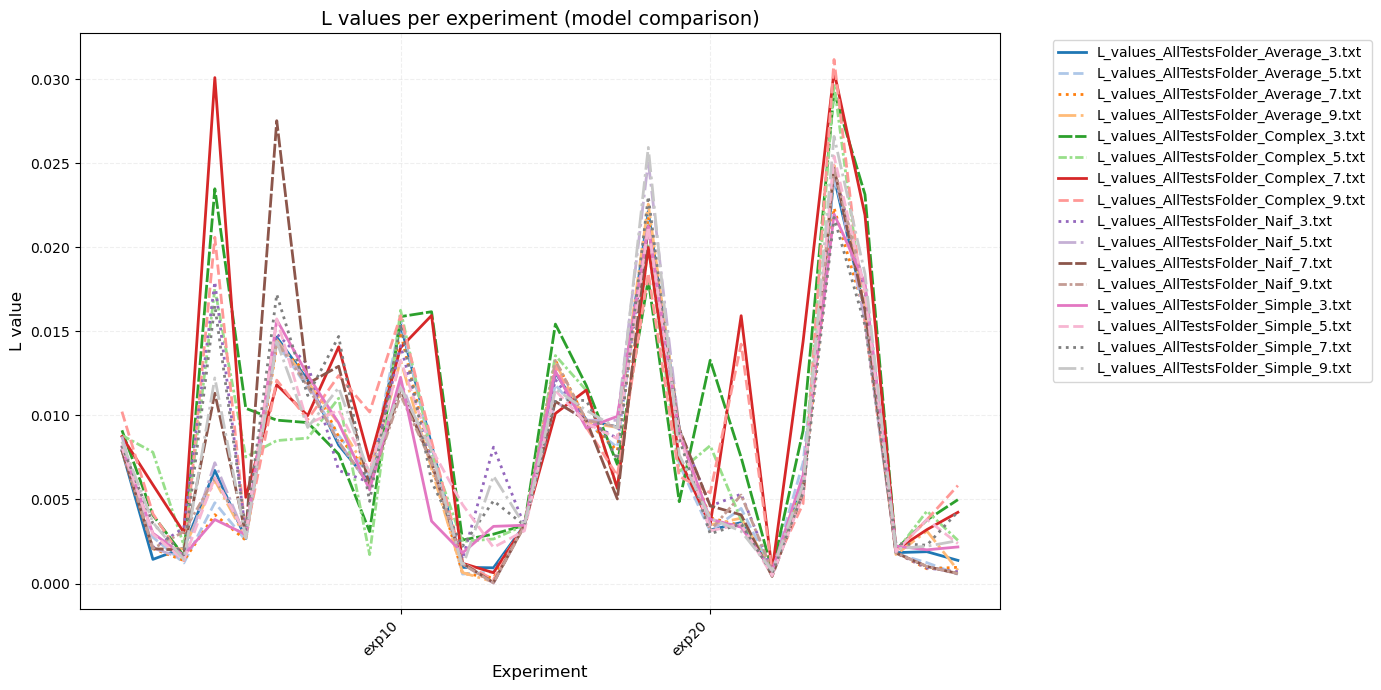

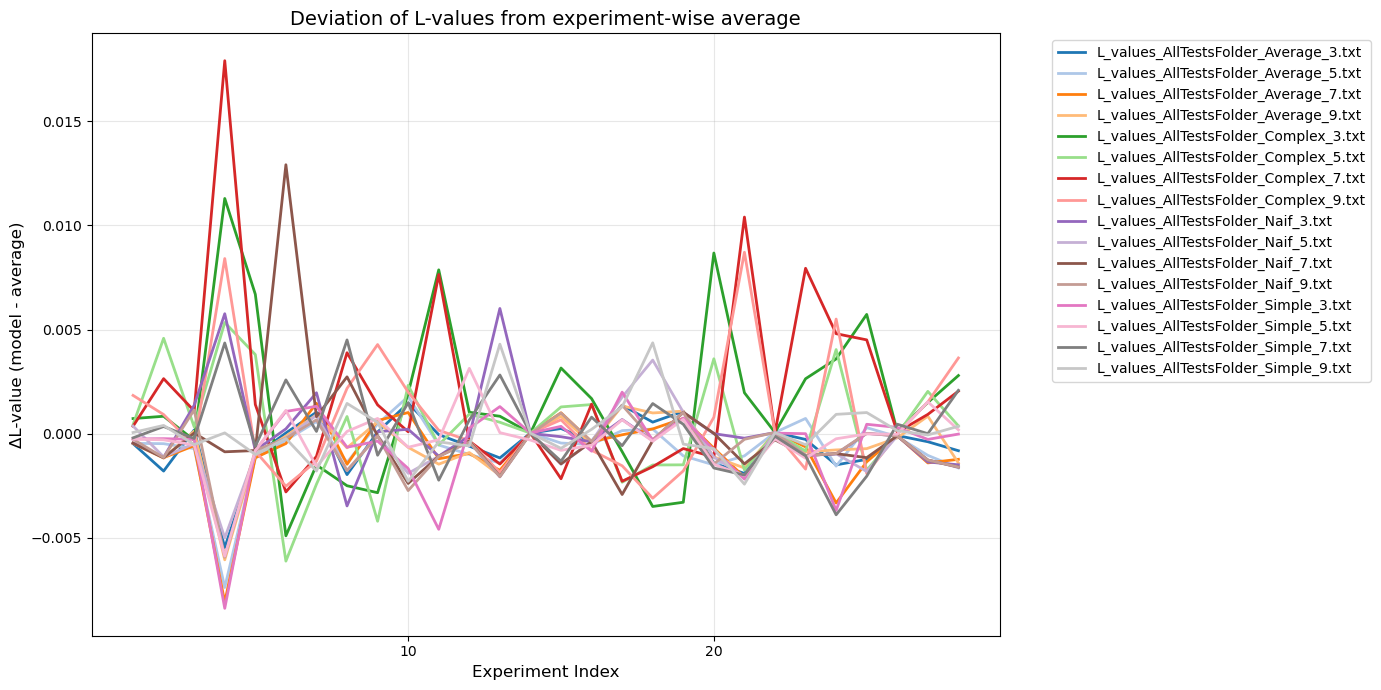

Scores saved to: \\?\C:\Users\perez-blasco\Desktop\FolderofFolders\TestAModelFolder\LTestVisualCheck\LValues\Lvalues_TotalScores.txt


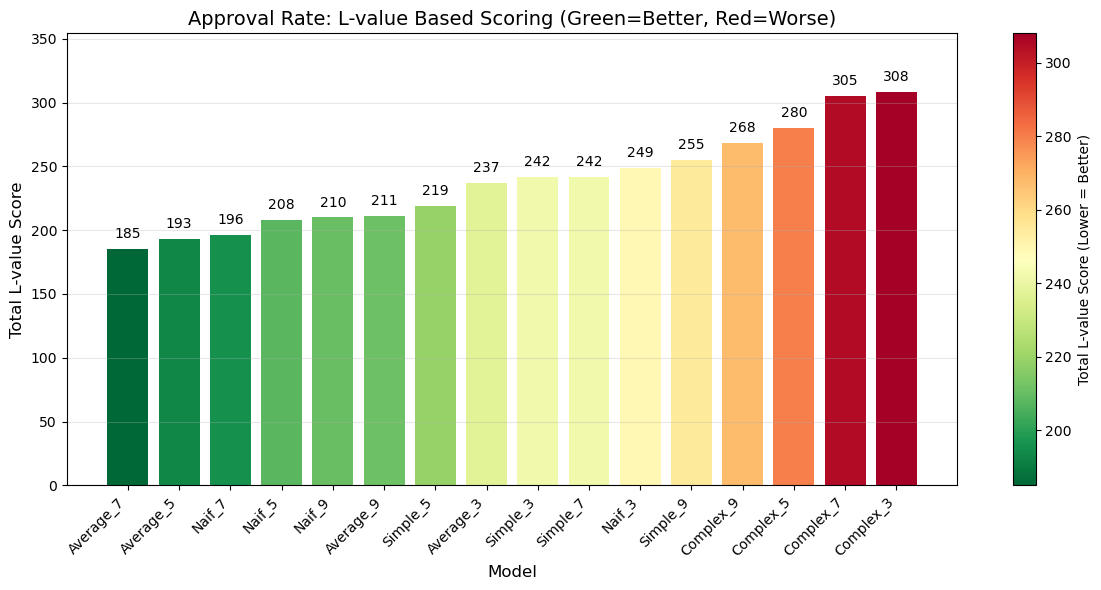

Winner-takes-all scores saved to: \\?\C:\Users\perez-blasco\Desktop\FolderofFolders\TestAModelFolder\LTestVisualCheck\LValues\Lvalues_WinnerScores.txt


In [14]:
import os
import pandas as pd
import numpy as np

def long_path(path):
    """Return Windows long path format if on Windows."""
    if os.name == 'nt':
        path = os.path.abspath(path)
        if not path.startswith('\\\\?\\'):
            return '\\\\?\\' + path
    return path

def compute_L_for_experiment(df_real, df_pred):
    """
    Compute the L value for one experiment.
    You need to define your L computation formula here.
    For example, mean squared error as a placeholder:
    
        L = (1/N) * Σ (pred - real)^2
    """
    if len(df_real) != len(df_pred):
        raise ValueError("Real and predicted files must have the same length.")
    
    N = len(df_real)
    diff = np.abs(df_pred["PredictedPolarizationD3"].values - df_real["RealPolarizationD3"].values)
    L = np.sum(diff) / N
    return L

def load_data(experiment_folder):
    """
    Load the txt files containing real and predicted data
    for a MissingPolarizationD3_* experiment.
    """
    experiment_folder = long_path(experiment_folder)
    files = os.listdir(experiment_folder)
    real_file = next(f for f in files if f.startswith("RawData_PolarizationD3_MissingPolarizationD3_"))
    pred_file = next(f for f in files if f.startswith("PredictedPoints_PolarizationD3_MissingPolarizationD3_"))

    df_real = pd.read_csv(long_path(os.path.join(experiment_folder, real_file)), sep="\t")
    df_pred = pd.read_csv(long_path(os.path.join(experiment_folder, pred_file)), sep="\t")
    return df_real, df_pred

def count_missing_folders(model_path):
    """
    Return the list of MissingPolarizationD3_* subfolders for a given model folder.
    """
    model_path = long_path(model_path)
    return sorted([
        f for f in os.listdir(model_path)
        if f.startswith("MissingPolarizationD3_") and os.path.isdir(long_path(os.path.join(model_path, f)))
    ])

def save_L_values_to_txt(model_folder_name, missing_folders, L_values, output_dir):
    """
    Save the L values to a structured text file
    inside the 'LValues' folder at the root level.
    """
    L_dir = long_path(os.path.join(output_dir, "LValues"))
    os.makedirs(L_dir, exist_ok=True)  # ensure folder exists

    filename = f"L_values_{model_folder_name}.txt"
    filepath = long_path(os.path.join(L_dir, filename))

    with open(filepath, "w") as f:
        for folder_name, L in zip(missing_folders, L_values):
            f.write(f"{folder_name}: {L:.6f}\n")

    print(f"File saved: {filepath}")

def main_all_models_L(root_folder):
    """
    Main loop over all model folders in the given root_folder.
    Each folder should contain MissingPolarizationD3_* subfolders.
    """
    root_folder = long_path(root_folder)
    all_model_folders = [
        d for d in os.listdir(root_folder)
        if os.path.isdir(long_path(os.path.join(root_folder, d)))
    ]

    if not all_model_folders:
        print("No model folders found.")
        return

    for model_folder in all_model_folders:
        model_path = long_path(os.path.join(root_folder, model_folder))
        missing_folders = count_missing_folders(model_path)

        if not missing_folders:
            print(f" No MissingPolarizationD3_ folders in {model_folder}")
            continue

        L_values = []
        for missing_folder in missing_folders:
            experiment_path = long_path(os.path.join(model_path, missing_folder))
            try:
                df_real, df_pred = load_data(experiment_path)
                L = compute_L_for_experiment(df_real, df_pred)
                L_values.append(L)
            except Exception as e:
                print(f"   Error in {missing_folder}: {e}")

        if L_values:
            save_L_values_to_txt(model_folder, missing_folders, L_values, root_folder)
            L_mean = np.mean(L_values)
        else:
            print(f"No valid L values computed for {model_folder}.")

# === Example call ===
main_all_models_L(r".")
import os
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np

def long_path(path):
    """Return Windows long path format if on Windows."""
    if os.name == 'nt':
        path = os.path.abspath(path)
        if not path.startswith('\\\\?\\'):
            return '\\\\?\\' + path
    return path

# Folder that contains the saved L value text files
folder_path = long_path("LValues")

# Quick diagnostic
if not os.path.isdir(folder_path):
    print(f"Folder not found: {folder_path}")
    print("   Tip: run the computation cell first so it creates LValues/ and the files.")
    
# Helper to recognize result files
def is_result_file(name: str) -> bool:
    return name.endswith(".txt") and name.startswith("L_values_")

# Initialize dictionaries
LValues = {}                # file -> {experiment_name: value}
ExperimentName = OrderedDict()  # experiment_name -> exp1, exp2, ...

# Collect files
result_files = []
if os.path.isdir(folder_path):
    for filename in os.listdir(folder_path):
        if is_result_file(filename):
            result_files.append(filename)

# Sort for stable order
result_files.sort()

if not result_files:
    print("No results found in LValues/ matching 'L_values_*.txt'.")
else:
    for filename in result_files:
        full_path = long_path(os.path.join(folder_path, filename))
        with open(full_path, "r") as f:
            lines = f.readlines()

        LValues[filename] = {}
        for line in lines:
            if ":" in line:
                try:
                    experiment_name, value = line.split(":", 1)
                    experiment_name = experiment_name.strip()
                    value = float(value.strip())
                    LValues[filename][experiment_name] = value
                except ValueError:
                    print(f"Skipping malformed line in {filename}: {line.strip()}")

        # Fill ExperimentName only from the first processed file
        if not ExperimentName and LValues[filename]:
            for i, experiment_name in enumerate(LValues[filename].keys(), 1):
                ExperimentName[experiment_name] = f"exp{i}"

# --- Plotting ---
plt.figure(figsize=(14, 7))

# List of experiment identifiers (exp1, exp2, ...)
exp_ids = list(ExperimentName.values())

# Ensure we have at least 2 models
assert len(LValues) >= 2, "You need at least two L values files"

# List of files to plot (model names)
files = list(LValues.keys())

# Use modern colormap handling
colors = plt.colormaps.get_cmap('tab20').colors
line_styles = ['-', '--', ':', '-.', (0, (5, 1)), (0, (3, 1, 1, 1))]
line_widths = [2] * len(files)

# Plot the curves
for j, filename in enumerate(files):
    L_values = [
        LValues[filename].get(exp_name, np.nan)  # Use NaN if missing
        for exp_name in ExperimentName.keys()
    ]
    
    plt.plot(
        range(len(exp_ids)),
        L_values,
        color=colors[j % len(colors)],
        linestyle=line_styles[j % len(line_styles)],
        linewidth=line_widths[j],
        label=filename
    )

# Show xticks every 10 experiments
xticks_pos = [i for i in range(len(exp_ids)) if (i + 1) % 10 == 0]
xticks_labels = [exp_ids[i] for i in xticks_pos]
plt.xticks(xticks_pos, xticks_labels, rotation=45, ha='right')

# Labels and title
plt.xlabel("Experiment", fontsize=12)
plt.ylabel("L value", fontsize=12)
plt.title("L values per experiment (model comparison)", fontsize=14)
plt.grid(alpha=0.2, linestyle='--')

# Legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# --- Normalize experiment names ---
def normalize_key(k):
    return k.replace("-", "_")

# Normalize experiment names inside LValues
LValues_norm = {
    model: {normalize_key(exp): val for exp, val in LValues[model].items()}
    for model in LValues
}

# Normalize experiment names mapping
ExperimentName_norm = {normalize_key(exp): exp for exp in ExperimentName.keys()}

# Build 2D array: rows = models, cols = experiments
all_L_values = np.array([
    [LValues_norm[f].get(exp, np.nan) for exp in ExperimentName_norm.keys()]
    for f in LValues_norm.keys()
])

# Preserve the original experiment order (exp1, exp2, ...)
exp_ids = [ExperimentName_norm[exp] for exp in ExperimentName_norm.keys()]

# Keep track of model names (rows of all_L_values)
model_ids = list(LValues_norm.keys())

# --- Debugging output ---
#print("Shape of all_L_values:", all_L_values.shape)
#print("Models:", model_ids)
#print("Experiments:", exp_ids[:10], "...")  # only show first 10 for sanity check
import matplotlib.pyplot as plt
import numpy as np
import os

# --- Ensure output folder exists ---
output_folder = long_path("LValues")
os.makedirs(output_folder, exist_ok=True)

# --- Build L-value matrix ---
files = list(LValues.keys())   # Model names
nb_models = len(files)
exp_ids = list(ExperimentName.keys())  # Experiments in original order

all_L_values = []
for f in files:
    model_vals = []
    for exp in exp_ids:
        model_vals.append(LValues[f].get(exp, np.nan))  # fill missing with NaN
    all_L_values.append(model_vals)
all_L_values = np.array(all_L_values)

# --- Compute average L-value across models for each experiment ---
avg_L = np.nanmean(all_L_values, axis=0)

# --- Colors ---
colors = plt.colormaps['tab20'](range(nb_models))

# --- Plot deviation from the average ---
plt.figure(figsize=(14, 7))  # 0.2 inch per experiment, capped at 50 inches
for j in range(nb_models):
    diff_from_avg = all_L_values[j] - avg_L
    plt.plot(
        range(1, len(exp_ids) + 1),
        diff_from_avg,
        linewidth=2,
        color=colors[j % len(colors)],
        label=files[j]
    )

# X-ticks every 10 experiments
xticks_pos = [k + 1 for k in range(len(exp_ids)) if (k + 1) % 10 == 0]
plt.xticks(xticks_pos, rotation=0)

plt.xlabel("Experiment Index", fontsize=12)
plt.ylabel("ΔL-value (model - average)", fontsize=12)
plt.title("Deviation of L-values from experiment-wise average", fontsize=14)
plt.grid(alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

nb_models = len(files)
nb_experiments = len(exp_ids)

# Initialize score dictionary
model_scores_L = {f: 0 for f in files}

# Loop over experiments
for exp_idx in range(nb_experiments):
    # Get L-values for all models in this experiment
    l_vals = all_L_values[:, exp_idx]

    # Handle NaNs: treat them as -inf so they get the lowest score
    l_vals_safe = np.where(np.isnan(l_vals), -np.inf, l_vals)

    # Get ranking: argsort sorts ascending, so we reverse for descending
    ranks = np.argsort(l_vals_safe)  # ascending order
    # Convert to scores: lowest gets 1, highest gets nb_models
    scores = np.empty_like(ranks, dtype=int)
    scores[ranks] = np.arange(1, nb_models + 1)

    # Add to cumulative model scores
    for model_idx, f in enumerate(files):
        model_scores_L[f] += scores[model_idx]

# Sort by descending score
sorted_scores_L = sorted(model_scores_L.items(), key=lambda x: x[1], reverse=True)


# --- Save results to text (integer scores) ---
output_file = os.path.join(output_folder, "Lvalues_TotalScores.txt")
with open(output_file, "w") as f:
    f.write("Approval Rate (Total L-value score. Higher = Better):\n\n")
    for model, score in sorted_scores_L:
        f.write(f"{model}: {score} points\n")  # integer score
print(f"Scores saved to: {output_file}")

# --- Vertical bar chart (integer scores) ---
models = [m for m, _ in sorted_scores_L]
scores = [s for _, s in sorted_scores_L]

# Normalize colors for plotting
norm = plt.Normalize(min(scores), max(scores))
cmap = plt.colormaps['RdYlGn']  # green = high score, red = low
colors = cmap(norm(scores))
import re  # Needed for regex

# Short model names for X-axis
short_models = []
pattern = r"L_values_AllTestsFolder_(.+)\.txt"  # capture only the middle part
for m in models:
    match = re.match(pattern, m)
    if match:
        short_models.append(match.group(1))
    else:
        short_models.append(m)  # fallback if pattern not matched
norm = plt.Normalize(min(scores), max(scores))
cmap = plt.colormaps['RdYlGn_r']   # reversed: low=green, high=red
colors = cmap(norm(scores))
# --- Sort models by ascending score (lower = better, leftmost) ---
sorted_scores_L = sorted(model_scores_L.items(), key=lambda x: x[1])  
models = [m for m, _ in sorted_scores_L]
scores = [s for _, s in sorted_scores_L]

# --- Short names for X-axis ---
short_models = [m.replace("L_values_AllTestsFolder_", "").replace(".txt", "") for m in models]

# --- Color mapping (inverted so low=green, high=red) ---
norm = plt.Normalize(min(scores), max(scores))
cmap = plt.colormaps['RdYlGn_r']
colors = cmap(norm(scores))

# --- Plot ---
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(short_models, scores, color=colors)

# Add integer score labels above bars
for bar, score in zip(bars, scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.02*max(scores),
            f"{score}", ha='center', va='bottom', fontsize=10)

# Make y-axis taller so labels fit
ax.set_ylim(0, max(scores) * 1.15)

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(scores)
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Total L-value Score (Lower = Better)")

ax.set_ylabel("Total L-value Score", fontsize=12)
ax.set_xlabel("Model", fontsize=12)
ax.set_title("Approval Rate: L-value Based Scoring (Green=Better, Red=Worse)", fontsize=14)
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig(long_path(os.path.join(output_folder, "Lvalues_rank_vertical.png")), dpi=300, bbox_inches='tight')
plt.show()

# --- Winner-takes-all scoring (best model per experiment gets +1) ---
winner_scores = {f: 0 for f in files}

for exp_idx in range(all_L_values.shape[1]):  # iterate over experiments
    exp_values = all_L_values[:, exp_idx]  # all models' L-values for this experiment

    # Skip if all values are NaN
    if np.all(np.isnan(exp_values)):
        continue

    # Get index of model with the smallest L-value
    best_idx = np.nanargmin(exp_values)
    best_model = files[best_idx]

    # Award +1 to the winner
    winner_scores[best_model] += 1

# --- Sort results (descending: more wins is better) ---
sorted_winner_scores = sorted(winner_scores.items(), key=lambda x: x[1], reverse=True)

# --- Save results to text file ---
output_file_winner = os.path.join(output_folder, "Lvalues_WinnerScores.txt")
with open(output_file_winner, "w") as f:
    f.write("Winner-Takes-All Approval Rate (Each experiment's best model gets +1):\n\n")
    for model, score in sorted_winner_scores:
        f.write(f"{model}: {score} wins\n")

print(f"Winner-takes-all scores saved to: {output_file_winner}")


<h1> PLOTS COMPARING THE MODELS</h1>

In [15]:
import os, glob, re
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image

search_root = Path.cwd()
output_dir = search_root / "ExperimentComparison"
output_dir.mkdir(exist_ok=True)

# Look for any Missing*.jpg in all subfolders
all_images = sorted(glob.glob(str(search_root / "**" / "Missing*.jpg"), recursive=True))
print(f"Found {len(all_images)} images total.")

# Row ordering
priority = {"Naif": 0, "Simple": 1, "Average": 2, "Complex": 3}
row_regex = re.compile(r"(Naif|Simple|Average|Complex)", re.IGNORECASE)
aug_regex = re.compile(r"(\d+)(?!.*\d)")  # last number

def extract_row_aug(folder_name: str):
    row_match = row_regex.search(folder_name)
    row_name = row_match.group(1).capitalize() if row_match else None
    row_order = priority.get(row_name, 999)

    aug_match = aug_regex.search(folder_name)
    try:
        aug = int(aug_match.group(1)) if aug_match else 999
    except ValueError:
        aug = 999

    return row_order, aug
def shorten_exp_id(exp_id: str) -> str:
    """
    Take a long experiment ID like:
    'MissingPolarizationD3_234_polar_24_11_23_0_MillerIndex_(3,3,3)'
    and return just: '234_polar_24_11_23_0'
    """
    parts = exp_id.split("_")

    # Keep from the number (234 or 155K etc.) up to the last date part (before MillerIndex)
    try:
        miller_idx = parts.index("MillerIndex")
        core_parts = parts[1:miller_idx]  # skip 'MissingPolarizationD3'
    except ValueError:
        core_parts = parts[1:]  # if no MillerIndex, just drop first part

    return "_".join(core_parts)
# --- Group images ---
groups = {}
for p in all_images:
    p = Path(p)

    # Amorphous → experiment folder = parent.name (starts with Missing...)
    # Crystalline → experiment folder = stem of image (filename without extension)
    if p.parent.name.startswith("Missing"):
        exp_id = p.parent.name
    else:
        exp_id = p.stem  # filename without .jpg

    groups.setdefault(exp_id, []).append(p)

print(f"Found {len(groups)} experiment groups.")

# --- Build collages ---
for idx, (exp_id, paths) in enumerate(groups.items(), start=1):
    # Sort by model folder name (the parent’s parent)
    def sort_key(p: Path):
        model_folder = p.parents[1].name  # e.g. "AmorphousAllTestsFolder_Average_3"
        return extract_row_aug(model_folder)

    paths.sort(key=sort_key)

    fig, axes = plt.subplots(4, 4, figsize=(9, 6))
    axes = axes.flatten()

    for ax, img_path in zip(axes, paths):
        lp = r"\\?\{}".format(os.path.abspath(str(img_path)))  # Windows-safe
        if not os.path.exists(lp):
            print(f"WARNING: File not found: {lp}")
            ax.axis("off")
            continue

        img = Image.open(lp)
        ax.imshow(img)
        ax.set_title(img_path.parents[1].name, fontsize=8)  # model folder as title
        ax.axis("off")

    for ax in axes[len(paths):]:
        ax.axis("off")
    short_id = shorten_exp_id(exp_id)
    plt.tight_layout()
    save_name = output_dir / f"{short_id}.png"
    save_path = r"\\?\{}".format(os.path.abspath(str(save_name)))
    plt.savefig(save_path, bbox_inches="tight", dpi=1200)
    plt.close(fig)

    print(f"Saved {save_name}")


Found 448 images total.
Found 28 experiment groups.
Saved C:\Users\perez-blasco\Desktop\FolderofFolders\TestAModelFolder\LTestVisualCheck\ExperimentComparison\155K_2_18_9_23_1.png
Saved C:\Users\perez-blasco\Desktop\FolderofFolders\TestAModelFolder\LTestVisualCheck\ExperimentComparison\CaFeAl_1_5_6_24_0.png
Saved C:\Users\perez-blasco\Desktop\FolderofFolders\TestAModelFolder\LTestVisualCheck\ExperimentComparison\CaFeAl_31_5_24_0.png
Saved C:\Users\perez-blasco\Desktop\FolderofFolders\TestAModelFolder\LTestVisualCheck\ExperimentComparison\CaFeAl_3_6_6_25_0.png
Saved C:\Users\perez-blasco\Desktop\FolderofFolders\TestAModelFolder\LTestVisualCheck\ExperimentComparison\CuO_2_2_9_23_0.png
Saved C:\Users\perez-blasco\Desktop\FolderofFolders\TestAModelFolder\LTestVisualCheck\ExperimentComparison\EuAgAs_1_30_8_23_5.png
Saved C:\Users\perez-blasco\Desktop\FolderofFolders\TestAModelFolder\LTestVisualCheck\ExperimentComparison\EuAgAs_29_8_23_0.png
Saved C:\Users\perez-blasco\Desktop\FolderofFolder